In [102]:
import my_module.data_process as dp
import my_module.cal_input as ci
import torch
import torch.nn as nn
# import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [6]:
class Neural_Network(nn.Module):
    def __init__(self,n_feature, n_hidden_l1, n_hidden_l2): #n_hidden_l1 so neural tang thu nhat
                                                  #n_hidden_l2 so neural tang thu hai
        super().__init__() #khoi tao
        self.cal_hidden1 = nn.Linear(n_feature, n_hidden_l1)   #hidden layer 1
        self.relu1 = nn.ReLU()                                 #ham kich hoat layer 1
        self.cal_hidden2 = nn.Linear(n_hidden_l1, n_hidden_l2) #hidden layer 2
        self.relu2 = nn.ReLU()                                 #ham kich hoat layer 2
        self.cal_lout = nn.Linear(n_hidden_l2, 1)              #output layer
        self.out_act = nn.Sigmoid()                #gia tri ra
        
    def forward(self, x_input): #forward
        z1 = self.cal_hidden1(x_input)
        a1 = self.relu1(z1)
        z2 = self.cal_hidden2(a1)
        a2 = self.relu2(z2)
        z3 = self.cal_lout(a2)
        y = self.out_act(z3)
        return y

In [57]:
#Chuyển nhãn sang dạng 0, 1. 0-"-", 1-"+"
#Tham số:
    #file_name: Tên của tập chứa nhãn.
    #num_label: Nhãn của loại K-PTM nào - (S1, S2, S3, S4) - (1, 2, 3, 4)
#Trả về một ma trận cột chứa nhãn dạng nhị phân của các mẫu trong file có tên file_name
def Label_To_Bin(path_name, file_name, num_label):
    path_old = os.getcwd()
    os.chdir(path_name)
    f_read = open(file_name, "r")
    
    list_label = ["", "", "", ""]
    re = ""
    i = 0 #index của list_label
    for line in f_read:
        list_label[i] = "" + line
        i += 1
    re = list_label[num_label]
    re = re[0: len(re)-1] #Bo ki tu xuong dong
    matrix_b = np.ones((len(re), 1)) #ma trận lưu kết quả của chuyển đổi
    k = 0 #chi so hang cua matrix_b
    for ch in re:
        if(ch == "+"):
            matrix_b[k][0] = 1
        else:
            matrix_b[k][0] = 0
        k += 1
    os.chdir(path_old)
    f_read.close()
    return matrix_b

In [87]:
from sklearn.model_selection import KFold
class ModelData:
    path_data = "E:\\WinPython-64bit-3.5.4.0Qt5\\notebooks\\Neural_Network_Final\\Data"
    path_pro = "E:\\WinPython-64bit-3.5.4.0Qt5\\notebooks\\Neural_Network_Final\\Data\\K_PTM"
    file_label_name = "lable_data.txt"
    file_name_data = "data.txt"   
    list_pos_name = ["s1_pos.txt", "s2_pos.txt", "s3_pos.txt", "s4_pos.txt"]
    list_neg_name = ["s1_neg.txt", "s3_neg.txt", "s3_neg.txt", "s4_neg.txt"]
    def __init__(self, num_s):
        self.num_s = num_s # nhãn tương ứng, num_s = 0 thực hiện tính xác suất cho NN1
        #self.random_of_state = random_of_state #random of state của K-Fold
        self.list_train = [] #lưu các phần tử của tập train
        self.list_val = [] #lưu các phần tử của tập val
    def __Cal_Pro(self):
        pro_obj = ci.Probability(self.path_data, self.file_name_data, self.list_pos_name[self.num_s], self.list_neg_name[self.num_s], self.path_pro) #Xac suat cua tap du lieu doi voi nhan tuong ung
        self.probability = pro_obj.Cal_Probability()
    def __Label(self):
        self.label = Label_To_Bin(self.path_data, self.file_label_name, self.num_s) #Nhãn tương ứng sang dạng nhị phân
    def Active(self):
        self.__Cal_Pro() #tính xác xuất
        self.__Label() #Gán nhãn sang dạng nhị phân
    def Set_Random_Of_State(self, random_of_state):
        self.list_train.clear()
        self.list_val.clear()
        kfold = KFold(5, True, random_of_state) #Phân chia dữ liệu thành 5 -fold
        for train, val in kfold.split(self.probability): #Lấy các phần tử thuộc tập train và tập val của 5 fold
            self.list_train.append(train) #Lưu các phàn tử của tập train
            self.list_val.append(val) #lưu các phần tử của tập val
    def Train_And_Val(self, s): #s = 0-tập thứ nhất là tập val
        self.input_train = self.probability[self.list_train[s]] #input cho tập train
        self.input_val   = self.probability[self.list_val[s]] #input cho tập val
        self.label_train = self.label[self.list_train[s]]     #nhãn cho tập train
        self.label_val   = self.label[self.list_val[s]]       #nhãn cho tập val
        
        

In [117]:
#Thuộc tính:
    #net_num: mạng training cho loại K-PTM Snet_num, tính xác xuất trên Snet_num, net_num = (0, 1, 2, 3)
    #n_hidden_l1: Số neural tầng thứ nhất
    #n_hidden_l2: Số neural tầng thứ hai
class Model:
    Result = []   #Kết quả dự đoán - Thuộc tính lớp
    Label  = []   #Nhãn của dữ liệu - thuộc tính Lớp
    def __init__(self, data, net_num, n_hidden_l1, n_hidden_l2, time_train):
        self.net_num = net_num
        self.n_hidden_l1 = n_hidden_l1
        self.n_hidden_l2 = n_hidden_l2
        self.predicted = np.zeros((6393, 1))
        self.data = data
        self.time_train = time_train
    def Train_And_Predict(self):
        #k = 0
        list_loss = []
        self.Result.append(np.zeros((6393, 1)))#Mỗi lần gọi hàm sẽ khởi tạo cho list kết quả ở lần đó một ma trận 0, sau đó gán sau
        self.Label.append(self.data.label)     #thêm nhãn của tập dữ liệu hiện tại.
        print("NN ", self.net_num)
        for i_data in range(5): #i_data = 0 - dung tap data1 lam tap val
            list_loss.clear()
            count = 0
            net = Neural_Network(26, self.n_hidden_l1, self.n_hidden_l2)
            opt = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
            criterion = nn.BCELoss()
            
            self.data.Train_And_Val(i_data)  #Tính dữ liệu vào train và test
            input_net = torch.from_numpy(self.data.input_train).type(torch.FloatTensor)
            label_net = torch.from_numpy(self.data.label_train).type(torch.FloatTensor)
            net.train()
            for t in range(self.time_train):
                opt.zero_grad()                     #Xoa gradient cho lan train tiep theo
                y_hat = net(input_net)              #tinh output
                loss = criterion(y_hat, label_net)  #tinh loi
                loss.backward()                     #tinh gradinet
                opt.step()
                list_loss.append(loss.data.numpy())
            print("Loss train ",i_data)
            print("loss = ", loss.data.numpy())
            plt.plot(list_loss)
            plt.show()
            #Predict
            input_val = torch.from_numpy(self.data.input_val).type(torch.FloatTensor) #input vadilation
            net.eval()
            outputs = net(input_val).data.numpy()  #Tính output của mạng với tập val sau khi train
            #Tính kết quả 
            for i in range(outputs.shape[0]):
                if(outputs[i][0] >= 0.5):
                    self.Result[self.net_num][self.data.list_val[i_data][i]][0] = 1  #Gán dữ liệu tính được vào tập Result
                elif(outputs[i][0] < 0.5):
                    self.Result[self.net_num][self.data.list_val[i_data][i]][0] = 0  #Gán dữ liệu tính được vào tập Result
                #k += 1   
                
                if(((outputs[i][0] >= 0.5) & (self.data.label_val[i][0] == 1)) | ((outputs[i][0] < 0.5) & (self.data.label_val[i][0] == 0))):    
                    count += 1
            prob = count*100/outputs.shape[0]
            print("predict_data%s" % (i_data), prob)

In [110]:
class MeasuringMetrics:
    def __init__(self, predict_data, label_data):
        self.predict_data = predict_data
        self.label_data = label_data
        self.Aming = 0
        self.Coverage = 0
        self.Accuracy = 0
        self.Absolute_True = 0
        self.Absolute_False = 0
        #######

    def Cal(self):
        # Yk nhan da duoc quan sat thu nghiem
        # Zk nhan duoc du doan bang mo hinh mang
        total_sample = 6393
        count = 0
        for i_sample in range(6393):  # List co phan tu tuong ung voi 4 loai k-ptm
            delta = 0  # Bien delta de tinh Absolute-True
            flag = 0  # flag = 0 delta = 1, flag = 1 delata = 0
            uin_minus_inter = 0
            Yk_inter_Zk = 0
            Yk_uni_Zk = 0
            Yk = 0
            Zk = 0
            for i_list in range(4):
                if ((self.predict_data[i_list][i_sample][0] == 1) & (self.label_data[i_list][i_sample][0] == 1)):
                    Yk_inter_Zk += 1
                if (self.predict_data[i_list][i_sample][0] != self.label_data[i_list][i_sample][0]):
                    flag = 1;
                if (self.predict_data[i_list][i_sample][0] == 1):
                    Zk += 1
                if (self.label_data[i_list][i_sample][0] == 1):
                    Yk += 1
            if (flag == 1):
                delta = 0
            else:
                delta = 1

            if ((Yk == 0) & (Zk == 0)):
                Yk_inter_Zk = 1
            if (Yk == 0):
                Yk = 1
            if (Zk == 0):
                Zk = 1

            Yk_uni_Zk = Zk + Yk - Yk_inter_Zk
            uin_minus_inter = (Yk_uni_Zk - Yk_inter_Zk)

            self.Aming += Yk_inter_Zk / Zk
            self.Coverage += Yk_inter_Zk / Yk
            self.Accuracy += Yk_inter_Zk / Yk_uni_Zk
            self.Absolute_True += delta
            self.Absolute_False += (uin_minus_inter)/5
        self.Aming = self.Aming / total_sample
        self.Coverage = self.Coverage/total_sample
        self.Accuracy = self.Accuracy/total_sample
        self.Absolute_True = self.Absolute_True/total_sample
        self.Absolute_False = self.Absolute_False/total_sample

In [111]:
data0 = ModelData(0)
data1 = ModelData(1)
data2 = ModelData(2)
data3 = ModelData(3)

data0.Active()
data1.Active()
data2.Active()
data3.Active()

In [120]:
data0.Set_Random_Of_State(2)
data1.Set_Random_Of_State(2)
data2.Set_Random_Of_State(2)
data3.Set_Random_Of_State(2)
model0 = Model(data0, 0, 100, 64, 1400)
#model1 = Model(data1, 1, 64, 32, 1000)
#model2 = Model(data2, 2, 64, 32, 1000)
#model3 = Model(data3, 3, 64, 32, 1000)

NN  0
Loss train  0
loss =  0.2408977597951889


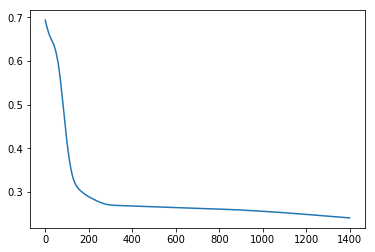

predict_data0 87.49022673964035
Loss train  1
loss =  0.19347919523715973


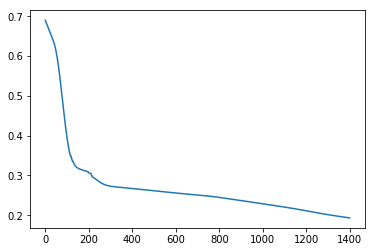

predict_data1 86.86473807662236
Loss train  2
loss =  0.19880609214305878


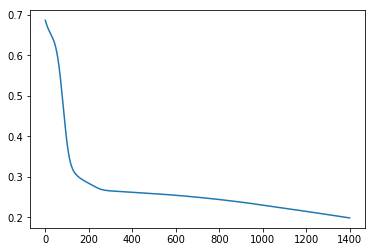

predict_data2 85.69194683346365
Loss train  3
loss =  0.22841939330101013


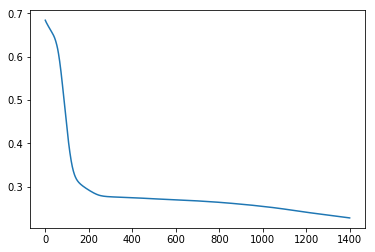

predict_data3 88.34115805946792
Loss train  4
loss =  0.20944160223007202


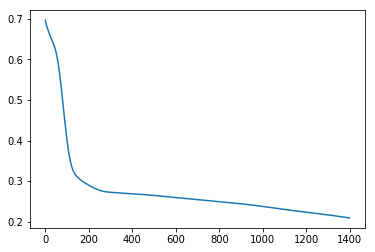

predict_data4 87.01095461658842


In [121]:
model0.Train_And_Predict()
#model1.Train_And_Predict()
#model2.Train_And_Predict()
#model3.Train_And_Predict()

In [84]:
me = MeasuringMetrics(Model.Result, Model.Label)
me.Cal()
print("Aming   : ",me.Aming)
print("Coverage: ",me.Coverage)
print("Accuracy: ",me.Accuracy)
print("Absolute_True", me.Absolute_True)
print("Absolute_False", me.Absolute_False)

Aming   :  0.8675634808905572
Coverage:  0.8693101830126702
Accuracy:  0.8534595130090202
Absolute_True 0.8230877522290004
Absolute_False 0.05940872829657345


In [50]:
#Tham số:
    #file_name: Tên của tập chứa nhãn.
    #num_label: Nhãn của loại K-PTM nào - (S1, S2, S3, S4) - (1, 2, 3, 4)
#Trả về một ma trận cột chứa nhãn dạng nhị phân của các mẫu trong file có tên file_name
def Label_To_Bin(path_name, file_name, num_label):
    path_old = os.getcwd()
    os.chdir(path_name)
    f_read = open(file_name, "r")
    
    list_label = ["", "", "", ""]
    re = ""
    i = 0 #index của list_label
    for line in f_read:
        list_label[i] = "" + line
        i += 1
    re = list_label[num_label]
    re = re[0: len(re)-1] #Bo ki tu xuong dong
    matrix_b = np.ones((len(re), 1)) #ma trận lưu kết quả của chuyển đổi
    k = 0 #chi so hang cua matrix_b
    for ch in re:
        if(ch == "+"):
            matrix_b[k][0] = 1
        else:
            matrix_b[k][0] = 0
        k += 1
    os.chdir(path_old)
    f_read.close()
    return matrix_b

path_data = "E:\\WinPython-64bit-3.5.4.0Qt5\\notebooks\\Neural_Network_Final\\Data"
file_label_name = "lable_data.txt"
s = Label_To_Bin(path_data, file_label_name, 3)
print(s)

[[ 0.]
 [ 1.]
 [ 1.]
 ..., 
 [ 0.]
 [ 0.]
 [ 0.]]


In [106]:
a1 = np.array([[1, 2, 4],
               [5, 6, 7]])
a2 = np.array([[2, 3, 4],
               [5, 8, 9]])
a3 = np.array([[2, 4, 5], 
               [8, 9, 0]])
a4 = np.array([[6, 8, 3],
               [4, 8, 9]])
list_matrix = [a1, a2, a3, a4]
dec = 0
i = 0; #Không gộp a4
for j in range(4):
    if((j != i) & (dec == 0)):
        a = list_matrix[j]
        dec = 1
    elif(j != i):
        a = np.concatenate((a, list_matrix[j]), axis = 0)
print(a)

[[2 3 4]
 [5 8 9]
 [2 4 5]
 [8 9 0]
 [6 8 3]
 [4 8 9]]


In [16]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#Chuyển nhãn sang dạng 0, 1. 0-"-", 1-"+"
#Tham số:
    #file_name: Tên của tập chứa nhãn.
    #num_label: Nhãn của loại K-PTM nào - (S1, S2, S3, S4) - (1, 2, 3, 4)
#Trả về một ma trận cột chứa nhãn dạng nhị phân của các mẫu trong file có tên file_name
def Label_To_Bin(file_name, num_label): 
    path_old = os.getcwd()
    os.chdir("E:\\WinPython-64bit-3.5.4.0Qt5\\notebooks\\Neural_Network_Final\\Data\\Train")
    f_read = open(file_name, "r")
    
    list_label = ["", "", "", ""]
    
    #Đọc dữ liệu từ file vào list_label
    i = 0 #index của list_label
    for line in f_read:
        list_label[i] = "" + line
        i += 1
        
    #Kiem tra đọc nhãn của loại nào
    re = ""
    for j in range(4):
        if((num_label) == j):
            re = list_label[j]
    re = re[0: len(re)-1] #Bo ki tu xuong dong
    
    #Chuyển nhãn của dữ liệu về ma trận cột dạng nhị phân
    matrix_b = np.ones((len(re), 1))
    k = 0 #chi so hang cua matrix_b
    for ch in re:
        if(ch == "+"):
            matrix_b[k][0] = 1
        else:
            matrix_b[k][0] = 0
        k += 1
    os.chdir(path_old)
    f_read.close()
    return matrix_b

In [ ]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#Lớp chứa dữ liệu đầu vào cho mạng
#Tham số của hàm khởi tạo:
    #num_s: Tính xác xuất trên tập s1 or s2 or s3 or s3, num_s = (0, 1, 2, 3)
#Các thuộc tính:
    #list_pro: List chứa xác xuất đầu vào cho mạng.
    #list_label_bin: List chứa các ma trận cột là nhãn đã chuyển về dạng nhị phân của 5 tập dữ liệu.
    #input_train: Đầu vào cho tập train
    #input_val: Đầu vào cho tập val
    #label_train: Nhãn của tập train
    #label_val: Nhãn của tập val
    #self.label: Nhãn của toàn bộ tập dữ liệu
class ModelData:
    path_train = "E:\\WinPython-64bit-3.5.4.0Qt5\\notebooks\\Neural_Network_Final\\Data\\Train"
    path_pro = "E:\\WinPython-64bit-3.5.4.0Qt5\\notebooks\\Neural_Network_Final\\Data\\K_PTM"
        
    list_pos_name = ["s1_pos.txt", "s2_pos.txt", "s3_pos.txt", "s4_pos.txt"]
    list_neg_name = ["s1_neg.txt", "s3_neg.txt", "s3_neg.txt", "s4_neg.txt"]
        
    list_data_name = ["data1.txt", "data2.txt", "data3.txt", "data4.txt", "data5.txt"]
    list_label_name = ["lable1.txt", "lable2.txt", "lable3.txt", "lable4.txt", "lable5.txt"]
    
    def __init__(self, num_s): #num_s: 0, 1, 2, 3
        self.num_s = num_s
        self.list_pro = []    #Lưu các xác xuất của tập 1 -> 5
        self.list_label_bin = []
    def __Cal_Pro(self):    #Tính xác xuất của 5 tập đối với loại K-PTM S_num_s     
        for i in range(4):
            if(i == (self.num_s)):  #Tinh xac suat doi voi tap num_s
                for j in range(5):
                    pro_o = ci.Probability(self.path_train,self.list_data_name[j], self.list_pos_name[i], self.list_neg_name[i], self.path_pro)
                    self.list_pro.append(pro_o.Cal_Probability())
    def __Label(self):  #Chuyen cac nhan sang danh nhi phan va luu cac thuoc tinh
        for i in range(5):
            self.list_label_bin.append(Label_To_Bin(self.list_label_name[i], self.num_s))
        #Gộp tất cả các nhãn của cả 5 tập dữ liệu với nhau:
        self.label = self.list_label_bin[0]
        for i in range(1, 5):
            self.label = np.concatenate((self.label, self.list_label_bin[i]), axis = 0)
            
    def Active(self):
        self.__Cal_Pro()  #Tinh xác xuat
        self.__Label()    #Chuyển nhãn sang dạng nhị phân
    def Train_And_Val(self, s):    #Ex: s = 0 - Tập data1 là tập val, còn lại gộp lại là tập train
        flag = 0
        for j in range(5):
            if((j != s) & (flag == 0)):
                self.input_train = self.list_pro[j]
                self.label_train = self.list_label_bin[j]
                flag = 1
            elif(j != s):
                self.input_train = np.concatenate((self.input_train, self.list_pro[j]), axis = 0)
                self.label_train = np.concatenate((self.label_train, self.list_label_bin[j]), axis = 0)
                
        self.input_val = self.list_pro[s]
        self.label_val = self.list_label_bin[s]
        #Gộp ma trận nhãn.